# Pytorch - FasterRCNN Inference

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt
from utils import format_prediction_string, predict_bbox, load_data, get_datasets, get_data_loader

# Set environment
ENV = 'gcloud' 

# Set data directory
if ENV == 'gcloud':
    DIR_INPUT = 'data'
elif ENV == 'kaggle':
    DIR_INPUT = '../input/global-wheat-detection'
else:
    print("Error: invalid environment specified")
    
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

DIR_WEIGHTS = '.'

# WEIGHTS_FILE = f'{DIR_WEIGHTS}/fasterrcnn_resnet50_fpn.pth'
WEIGHTS_FILE = f'{DIR_WEIGHTS}/best_weights.pth'

In [3]:
test_df = pd.read_csv(f'{DIR_INPUT}/sample_submission.csv')
test_df.shape

(10, 2)

# Init model

Load in the weights from our weights file

In [5]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load the trained weights
model.load_state_dict(torch.load(WEIGHTS_FILE))
model.eval()

x = model.to(device)

# Construct dataloader and make preds

In [6]:
# Load raw data
train_df, valid_df, test_df = load_data(DIR_INPUT, load = True)

# Turn off augment for inference
train_dataset, valid_dataset, test_dataset = get_datasets(train_df, valid_df, test_df, 
                                                          DIR_TRAIN, DIR_TEST, augment = False)

In [7]:
# Get data loader for training loop
BATCH_TR = 8
BATCH_VAL = 4
BATCH_TE = 4

train_data_loader = get_data_loader(train_dataset, 
                                    batch_size=BATCH_TR,
                                    drop_last=True)

valid_data_loader = get_data_loader(valid_dataset, 
                                    batch_size=BATCH_VAL, 
                                    shuffle=False)

test_data_loader = get_data_loader(test_dataset, 
                                   batch_size=BATCH_TE, 
                                   shuffle=False)

# Get image and boxes for image_id in test set

In [8]:
# Predict labels for new images
detection_threshold = 0.5
is_submission=False
results = []
images_dict = {}

for images, image_ids in test_data_loader:
    # save ids to a dict for plotting
    for image, image_id in zip(images, image_ids):
        images_dict[image_id] = image
        
    images = list(image.to(device) for image in images)
    results += predict_bbox(images, image_ids, model, detection_threshold, is_submission)    

if is_submission:
    new_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
else:
    new_df = pd.DataFrame(results, columns=['image_id','x1','y1','x2','y2'])

new_df

,image_id,x1,y1,x2,y2
0,aac893a91,554,527,683,724
1,aac893a91,611,916,698,1021
2,aac893a91,177,563,295,756
3,aac893a91,236,81,382,235
4,aac893a91,591,774,684,901
...,...,...,...,...,...
246,53f253011,524,401,602,474
247,53f253011,399,278,531,368
248,53f253011,136,630,231,747
249,53f253011,648,327,735,509


In [9]:
image_id = '53f253011'          

image = images_dict[image_id].permute(1,2,0).cpu().numpy()
boxes = new_df[new_df['image_id'] == image_id][['x1', 'y1', 'x2', 'y2']].to_numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


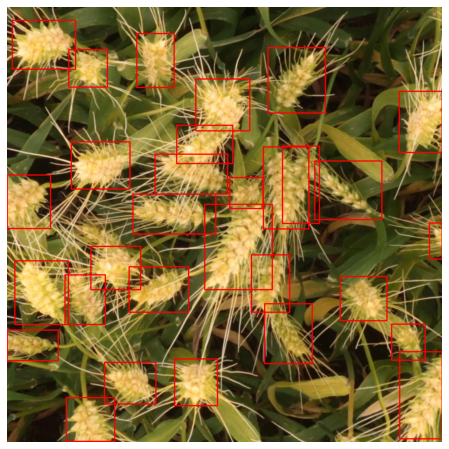

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(image,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 2)
    
ax.set_axis_off()
ax.imshow(image)

In [11]:
# test_df.to_csv('submission.csv', index=False)

# Inference on valid set

In [12]:
detection_threshold = 0.5
images, d = next(iter(valid_data_loader))
images = list(image.to(device) for image in images)

outputs = model(images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


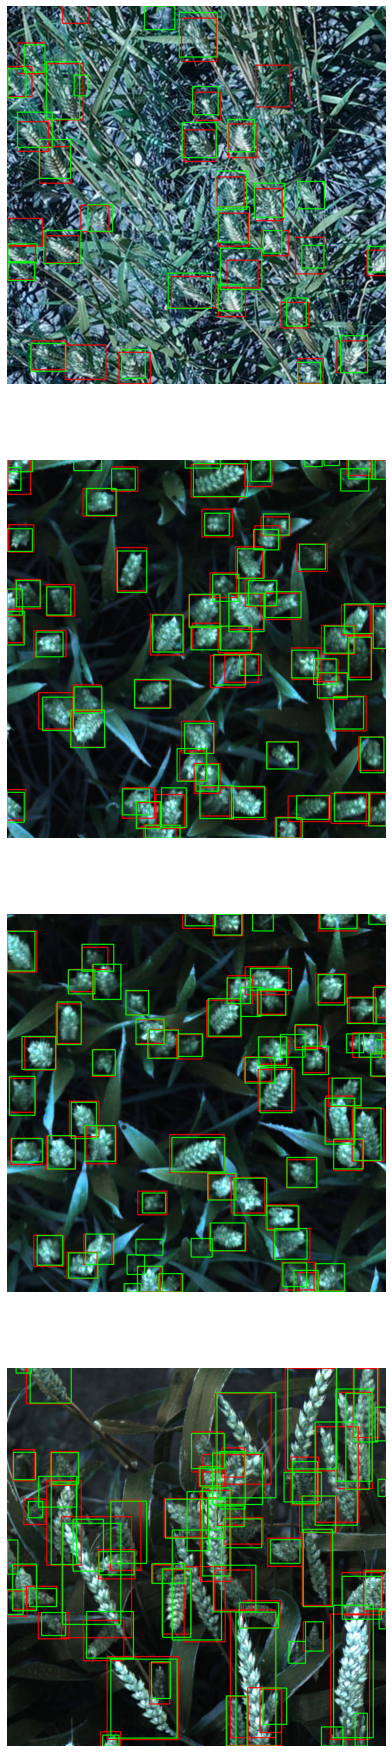

In [13]:
fig, ax = plt.subplots(BATCH_VAL, 1, figsize=(64, 32))

for i, image in enumerate(images):
    # get real boxes
    boxes_real = d[i]['boxes']
    # get predicted boxes
    boxes = outputs[i]['boxes'].data.cpu().numpy()
    scores = outputs[i]['scores'].data.cpu().numpy()
    
    # Cut off at probability score threshold
    boxes = boxes[scores >= detection_threshold].astype(np.int32)
    scores = scores[scores >= detection_threshold]
    reshaped_image = image.permute(1,2,0).cpu().numpy()
    
    for box in boxes:
        cv2.rectangle(reshaped_image,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (220, 0, 0), 2)

    for box in boxes_real:
        cv2.rectangle(reshaped_image,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (0, 220, 0), 2)

    ax[i].set_axis_off()
    ax[i].imshow(reshaped_image)

# Find the loss on val set

In [15]:
# model.load_state_dict(torch.load('fasterrcnn_resnet50_fpn2nd.pth'))

<All keys matched successfully>

In [16]:
from utils import Averager

model.train()
val_loss_hist = Averager()

# Validation Step
for images, targets in valid_data_loader:

    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    val_loss_dict = model(images, targets)

    val_losses = sum(loss for loss in val_loss_dict.values())
    val_loss_value = val_losses.item()

    val_loss_hist.send(val_loss_value)

# Augment 18 epoch

In [17]:
val_loss_hist.value

0.6024518091521577

# Augment 10 epoch

In [14]:
val_loss_hist.value

0.5961840993273044

# fasterrcnn_resnet50_fpn

In [19]:
val_loss_hist.value

0.684623579957528

# fasterrcnn_resnet50_fpn2nd

In [17]:
val_loss_hist.value

0.5644156561640208

# "best_weights" 2 epochs

In [12]:
val_loss_hist.value

0.6216460766192682